# exploration: correlations

### goal
The purpose of this notebook is to study the relationship between the variables. My goal is to shorten the list of necessary variables for my predictive model. My secondary goal is to create derived data that may have predictive power.

### problem
which variables should be included in the predictive model, and which ones should be excluded? Are there derived data that could be useful as well? Do we have any risk of multicollinearity?

### hypothesis
conducting a thorough correlation analysis, in which each predictor is analyzed versus the response variable, will answer all the questions in our problem.

### assumptions
* When doing correlation with 2 variables at a time, we are blind to the impact of variables not in that correlation.
* fewer predictors in the model is desirable
* There are assumptions about what each variable means listed throughout the notebook.

### procedure
* conduct global cluster maps of all variables when data is changed, removed, or added. This allows us to keep an eye on problematic correlations.
* look at the distribution of each predictor, in relation to the response 
* do calculations of statistical significance for categorical variables
* prune the data when an explanation for the trends observed can be quantitatively explained without the use of a predictive model


---

### imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

appointments_1 = pd.read_csv("data/appointments_clean.csv",
                          parse_dates=['scheduled_day','appointment_day'],
                          )
appointments_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110526 entries, 0 to 110525
Data columns (total 14 columns):
appointment_id     110526 non-null int64
patient_id         110526 non-null float64
scheduled_day      110526 non-null datetime64[ns]
appointment_day    110526 non-null datetime64[ns]
age                110526 non-null int64
neighborhood       110526 non-null object
scholarship        110526 non-null int64
hypertension       110526 non-null int64
diabetes           110526 non-null int64
alcoholism         110526 non-null int64
handicap           110526 non-null int64
sms_received       110526 non-null int64
no_show            110526 non-null int64
male               110526 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(10), object(1)
memory usage: 11.8+ MB


In [15]:
appointments_1.columns

Index(['appointment_id', 'patient_id', 'scheduled_day', 'appointment_day',
       'age', 'neighborhood', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'no_show', 'male'],
      dtype='object')

### clustermap 

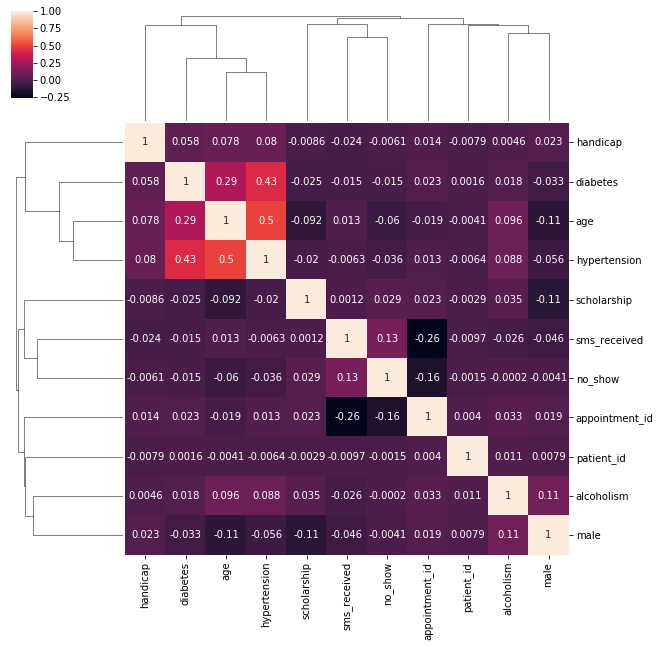

In [16]:
sns.clustermap(appointments_1.corr(), annot=True)

<div class='alert alert-danger'>
Do the correlations between age and hypertension mean that I should remove 1 of those predictors from my model? am I at risk of multicollinearity?
</div>

## days to appointment

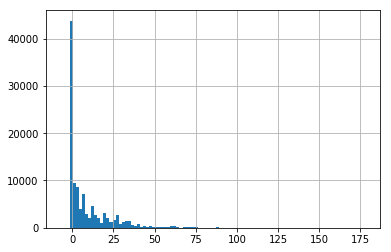

In [17]:
def daysToAppointment(row):
    return (row['appointment_day'] - row['scheduled_day']).days

appointments_1['days_to_appointment'] = appointments_1.apply(daysToAppointment,axis=1)
appointments_1['days_to_appointment'].hist(bins=100)

it looks like for the majority of appointments,the scheduled day comes after the appointment day. this can be explained by the fact that these appointments were walk-ins, and they were entered into the system after the appointment took place.
* walk-ins should be removed from the dataset, because our predictive model is only useful to predict appointments once they are scheduled

### remove walk-ins

In [18]:
appointments_2 = appointments_1[appointments_1['days_to_appointment'] >= 0]

In [19]:
(appointments_1.shape[0] - appointments_2.shape[0]) / appointments_1.shape[0] * 100

34.89405207824403

note that by removing walk-ins we reduce our data set by 34%

### plot

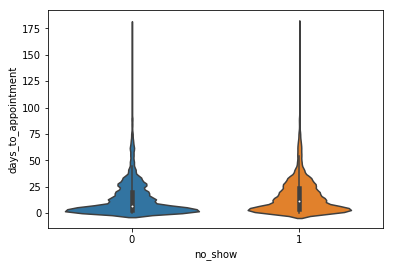

In [20]:
sns.violinplot(x='no_show',y='days_to_appointment',data=appointments_2)

<div class='alert alert-success'>
there is visually a difference in these distributions, so we should include this predictor in the model.
</div>

<div class="alert alert-danger">
to do: how do I check whether there is a statistically significant difference here?
</div>

## appointment count

what is the correlation between the frequency of patient appointment and no show?

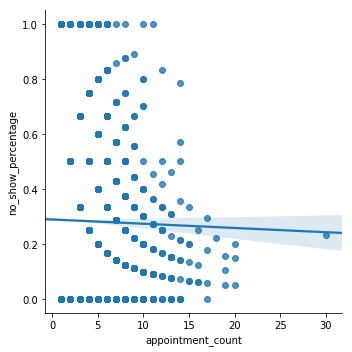

In [21]:
appointment_count = appointments_2.groupby('patient_id').count()['appointment_id']\
    .sort_values(ascending=False).to_frame(name='appointment_count')

no_show_count = appointments_2.groupby('patient_id').sum()['no_show']\
    .sort_values(ascending=False).to_frame(name='no_show_count')
    
frequencies = appointment_count.merge(no_show_count, left_index=True, right_index=True)
frequencies['no_show_percentage'] = frequencies['no_show_count']/frequencies['appointment_count']

sns.lmplot(x='appointment_count',y='no_show_percentage',data=frequencies)

<div class='alert alert-danger'>
I still need to do a test of statistical significance to decide if I should include appointment_count.
<li>what test of statistical significance do I need?
</div>

## male

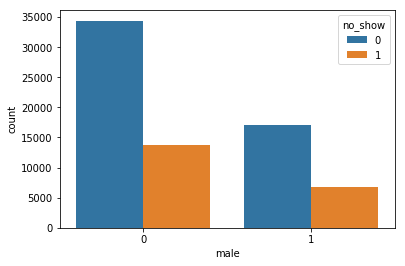

In [22]:
sns.countplot(x='male', hue='no_show', data=appointments_2)

there are twice as many women as men in the system.
* perhaps this is a culture where men are too proud to go to the doctor
* perhaps this is data taken from hospitals which have many births and take care of female reproductive health
* perhaps men die younger so most of the old population is female
* perhaps there is illness that targets females more than males

In [23]:
# number of male and female
total = appointments_2['male'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('male').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
0,48070,13674,28.446016
1,23889,6848,28.665913


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [24]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

0.2705769781762109

<div class='alert alert-warning'>
degrees of freedom = 1
<br>threshold = 3.841
<br>this is not statistically significant
</div>

## scheduled day

/Users/nico/code/pydata-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


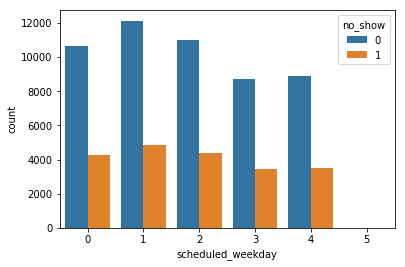

In [25]:
# convert the dates into days of the week
appointments_2['scheduled_weekday'] = appointments_2['scheduled_day'].dt.weekday
# appointments['scheduled_weekday'].value_counts()
sns.countplot(x='scheduled_weekday', hue='no_show', data=appointments_2)
# 0 is monday, 6 is sunday

In [26]:
total = appointments_2['scheduled_weekday'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('scheduled_weekday').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
1,16991,4859,28.597493
2,15437,4411,28.574205
0,14952,4277,28.604869
4,12412,3524,28.391879
3,12151,3450,28.392725
5,16,1,6.250000


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [27]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

3.0123193158544206

<div class='alert alert-warning'>
degrees of freedom = 5
<br>threshold = 11.07
<br>this is not statistically significant
</div>

## appointment day

/Users/nico/code/pydata-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


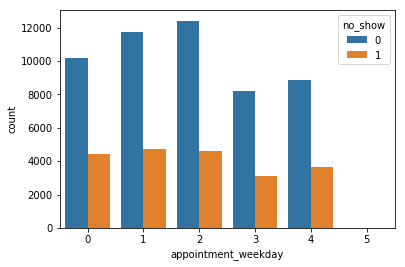

In [28]:
appointments_2['appointment_weekday'] = appointments_2['appointment_day'].dt.weekday
sns.countplot(x='appointment_weekday', hue='no_show', data=appointments_2)
# 0 is monday, 6 is sunday

In [29]:
total = appointments_2['appointment_weekday'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('appointment_weekday').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
2,17044,4627,27.147383
1,16462,4719,28.666019
0,14581,4405,30.210548
4,12516,3674,29.354426
3,11325,3088,27.267108
5,31,9,29.032258


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```

In [30]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

35.286920740966913

<div class='alert alert-success'>
degrees of freedom = 5
<br>threshold  = 11.07
<br>difference between days of the week is statistically significant
</div>

<div class='alert alert-danger'>
There is a very high difference between my chi-square and the threshold. but documentation about chi-square tells me that this test is only a binary indicator, i.e.it can only tell you if something is or is not statistically significant.
<li> is there a way to quantify the magnitude of this significance?
</div>

## age

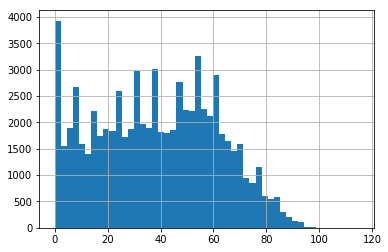

In [31]:
appointments_2['age'].hist(bins=50) 

In [32]:
appointments_2['age'].min()

0

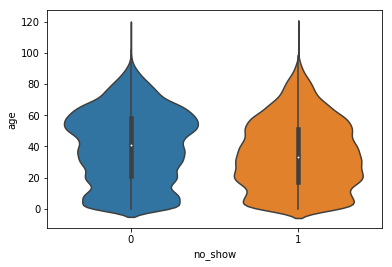

In [33]:
sns.violinplot(x='no_show',y='age',data=appointments_2)

the distribution of no-shows varies by age. how can I plot this meaningfully?

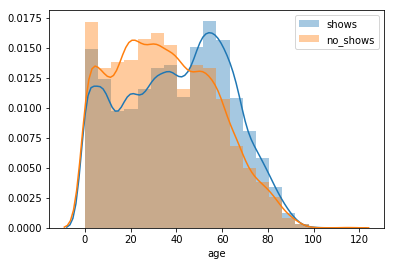

In [34]:
shows = appointments_2[appointments_2['no_show'] == 0]
no_shows = appointments_2[appointments_2['no_show'] == 1]

sns.distplot(shows['age'],bins=20,label='shows')
sns.distplot(no_shows['age'],bins=20,label='no_shows')
plt.legend()

### age versus no_show_percentage

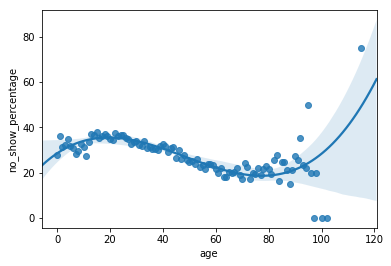

In [68]:
total = appointments_2['age'].value_counts().to_frame(name='total')

no_shows = appointments_2.groupby('age').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df = df.reset_index()
df = df.rename(columns={'index': 'age'})
sns.regplot(x='age',y='no_show_percentage',data=df,order=3)

<div class='alert alert-danger'>
the relationship between age and no-show is definitely not linear. 
<li>is there a way I intelligently incorporate this into my models?
<li>should I add to no show percentage as a feature?
</div>

## neighborhood

it would be nice to know the average income of each neighborhood, but I cannot find this information online.

In [36]:
total = appointments_2['neighborhood'].value_counts().to_frame(name='total')
total.head(10)

,total
JARDIM CAMBURI,5213
MARIA ORTIZ,3730
RESISTÊNCIA,2818
JARDIM DA PENHA,2655
ITARARÉ,2381
CENTRO,2270
TABUAZEIRO,1924
JESUS DE NAZARETH,1755
BONFIM,1708
CARATOÍRA,1691


In [37]:
no_shows = appointments_2.groupby('neighborhood').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
JARDIM CAMBURI,5213,1359,26.069442
MARIA ORTIZ,3730,1138,30.509383
RESISTÊNCIA,2818,857,30.411639
JARDIM DA PENHA,2655,597,22.485876
ITARARÉ,2381,869,36.497270
CENTRO,2270,653,28.766520
TABUAZEIRO,1924,526,27.338877
JESUS DE NAZARETH,1755,658,37.492877
BONFIM,1708,513,30.035129
CARATOÍRA,1691,541,31.992904


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```

In [38]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

361.79091511035256

<div class='alert alert-success'>
degrees of freedom = 79
<br>threshold  = 100.749 
<br>this is statistically significant
</div>

## scholarship

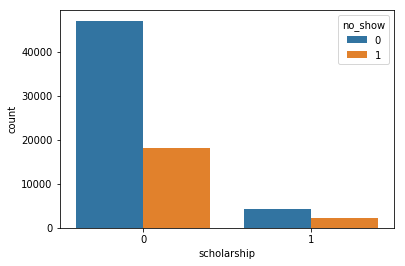

In [39]:
sns.countplot(x='scholarship', hue='no_show', data=appointments_2)

In [40]:
total = appointments_2['scholarship'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('scholarship').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
0,65288,18189,27.859637
1,6671,2333,34.972268


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [41]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

107.36559751342112

<div class='alert alert-success'>
degrees of freedom = 1
<br>threshold = 3.841
<br>this is statistically significant
</div>

Scholarships are financial assistance given to poor families. According to this, patients who receive scholarships are more likely to miss appointments.
* is financial wealth a stronger indicator for whether someone will miss appointment? it is possible that by separating by scholarship, we are mostly separating by wealth.

## hypertension

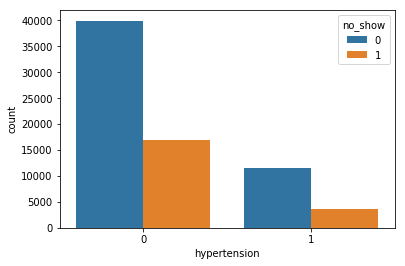

In [42]:
sns.countplot(x='hypertension', hue='no_show', data=appointments_2)

In [43]:
total = appointments_2['hypertension'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('hypertension').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
0,56927,16986,29.838214
1,15032,3536,23.523151


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [44]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

166.29178282461262

<div class='alert alert-success'>
degrees of freedom = 1
<br>threshold = 3.841
<br>this is statistically significant
</div>

Those without hypertension are more likely to miss an appointment. This is intuitive, as people with poor health conditions are more likely to take their care seriously.

<div class='alert alert-danger'>
if I have too many predictors that are all statistically significant, how do I prioritize which ones to include in my model? There must be a test of'more' significance. 
<li>perhaps I just make the model, then remove those with lower coefficients
<li>perhaps I look for multicollinearity, and try to get rid of that.
</div>


## diabetes

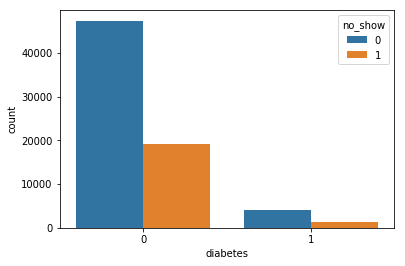

In [45]:
sns.countplot(x='diabetes', hue='no_show', data=appointments_2)

In [46]:
total = appointments_2['diabetes'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('diabetes').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
0,66582,19180,28.806584
1,5377,1342,24.958155


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [47]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

25.837126105071189

<div class='alert alert-success'>
<li>degrees of freedom = 1
<li>threshold = 3.841
<li>this is statistically significant
</div>

Those without diabetes are more likely to miss an appointment. This is intuitive, as people with poor health conditions are more likely to take their care seriously.

## alcoholism

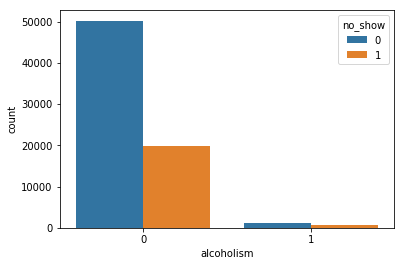

In [48]:
sns.countplot(x='alcoholism', hue='no_show', data=appointments_2)

In [49]:
total = appointments_2['alcoholism'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('alcoholism').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
0,70137,19901,28.374467
1,1822,621,34.083425


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [50]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

20.29502190338949

<div class='alert alert-success'>
<li>degrees of freedom = 1
<li>threshold = 3.841
<li>this is statistically significant
</div>

Alcoholics are more likely to miss their appointments. This is intuitive because alcoholism is correlated with difficulty in taking responsibility.

## handicap

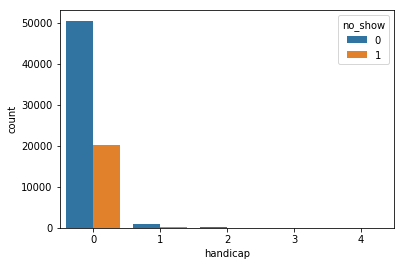

In [51]:
sns.countplot(x='handicap', hue='no_show', data=appointments_2)

Since there is so little data for the handicap levels 1, 2, 3, 4, I am going to combine them into a binary handicap column.

In [52]:
def sortHandicap(entry):
    if entry > 0:
        return 1
    else:
        return 0
    
appointments_2['handicap_binary'] = appointments_2['handicap'].apply(sortHandicap)

/Users/nico/code/pydata-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


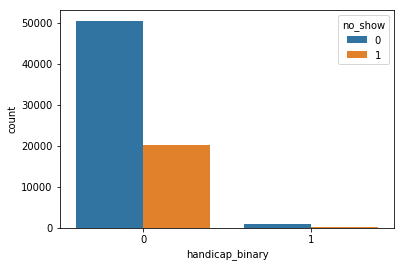

In [53]:
sns.countplot(x='handicap_binary', hue='no_show', data=appointments_2)

In [54]:
total = appointments_2['handicap_binary'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('handicap_binary').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
0,70652,20188,28.573855
1,1307,334,25.554705


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [55]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

4.1015650825805698

<div class='alert alert-warning'>
<li> degrees of freedom = 1
<li> threshold = 3.841
<li> this is not statistically significant
</div>

## sms received

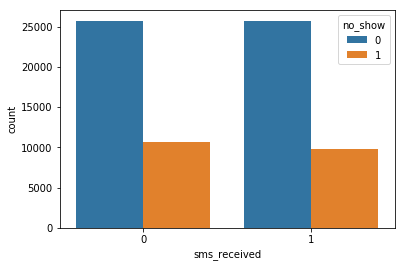

In [56]:
sns.countplot(x='sms_received', hue='no_show', data=appointments_2)

In [57]:
total = appointments_2['sms_received'].value_counts().to_frame(name='total')
no_shows = appointments_2.groupby('sms_received').sum()['no_show'].to_frame(name='no_shows')
df = total.merge(no_shows,left_index=True,right_index=True)

df['no_show_percentage'] = df['no_shows']/df['total']*100
df

,total,no_shows,no_show_percentage
0,36477,10738,29.437728
1,35482,9784,27.574545


### significance test: chi-square
```
chi-square score = 
    sum of categories(
        (expected - observed)**2 / expected
    )

degrees of freedom = 
    (# predictor values - 1) * (# target values - 1)
    
probability of error  = 
    p < 0.05
```



In [58]:
df['expected_frequency'] = df['total'] * df['no_shows'].sum() /df['total'].sum()

df['chi-square'] = (df['expected_frequency'] - df['no_shows'])**2 / df['expected_frequency']
df['chi-square'].sum()

21.893670001159016

<div class='alert alert-success'>
<li>degrees of freedom = 1
<li> threshold = 3.841
<li> this is statistically significant
</div>

sending an sms very slightly increases the likelihood that someone will show up to their appointment.

## Conclusion

### Predictors in model
Based on the above analysis, I will include the following predictors in my model:

* days_to_appointment
* age
* appointment_weekday
* neighborhood
* scholarship
* hypertension
* diabetes
* handicap_binary
* sms_received

### pruned dataset
Note that I will train this model on a pruned dataset: appointments_2. This dataset is approximately 35% smaller than the original. Most significantly, I removed the patients who had more than 20 appointments, and I removed the patients who had walk-ins. As a result I expect to have a much more accurate model, with the caveat that you independently predict the outcome for patients who have had more than 20 appointments. Walk-ins are a nonissue, as the goal here is not to predict walk ins.

### link to next section
[predictive_models](predictive_models.ipynb)

## export

In [59]:
appointments_2.to_csv('data/appointments_2.csv')